**Authors:**
- Carolina López De La Madriz (100475095)
- Álvaro Martín Ruiz (100475318)
- Jaime Salafranca Pardo (100475216)
- Emma Rodríguez Hervás (100475XXX)

**Course:** Machine Learning Application

---

## Overview

This project aims to apply the techniques and methodologies learned throughout the course *Machine Learning Applications* to address a relevant and socially impactful task: **detecting fake news in text documents**. The primary goal is to develop a system capable of distinguishing between real and fake news articles by considering Natual Language Processing (NLP), text vectorization techniques, and machine learning models.

The project consists of the following tasks:

• Task 1. Natural Language Processing and text vectorization

• Task 2. Machine Learning:

– Task 2.1. Classification, Regression using feature extraction or selection techniques

– Task 2.2. Clustering using feature extraction or selection techniques

– Task 2.3. Recommendation Systems

• Task 3. Implementation of a dashboard using the Python Dash library.

• Task 4. Final report and presentation.

For the execution of the final project, students must choose to implement
any of the sub-Tasks 2 (either 2.1, 2.2 or 2.3), depending on their preferences
and the possibilities of the database used.


In [5]:
!pip install gensim
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 9.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import ast
tqdm.pandas()

# Natural Text Processing
import spacy
from bs4 import BeautifulSoup
import re
import nltk

def check_nltk_packages():
  packages = ['punkt','stopwords','omw-1.4','wordnet']

  for package in packages:
    try:
      nltk.data.find('tokenizers/' + package)
    except LookupError:
      nltk.download(package)
check_nltk_packages()


try:
  import contractions
except ModuleNotFoundError:
  !pip install contractions
  import contractions



from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis
import pyLDAvis.gensim_models



# Classification tools
from sklearn.model_selection import train_test_split,  GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

seed = 10

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.5 MB/s eta 0:00:00


## DATASET

In [4]:
df_false = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')
df = pd.read_csv('fake_or_real_news.csv')

In [ ]:
print(df_false.shape)
print(df_true.shape)
print(df.shape)

(23481, 4)
(21417, 4)
(6335, 4)


In [ ]:
df_false['target'] = 1
df_true['target'] = 0
print(df_false['subject'].unique())
print(df_true['subject'].unique())
df_false.head()

df_total = pd.concat([df_false, df_true], ignore_index=True).drop(columns=['date','subject'])
df_total = df_total.sample(frac=1, random_state=seed).reset_index(drop=True)
df_total.head()

['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']
['politicsNews' 'worldnews']


title  \
0   WATCH: Republicans Disrespectfully Shout Down...   
1  Saudi Arabia says U.N. report on Yemen 'inaccu...   
2   Watch Morning Joe’s Mika DESTROY Paul Ryan Fo...   
3      House Democrats mull Pelosi leadership future   
4  BREAKING: MI Court Of Appeals Orders Vote Reco...   

                                                text  target  
0  Democrats stood up for the American people but...       1  
1  UNITED NATIONS (Reuters) - Saudi Arabia on Fri...       0  
2  Republican House Speaker Paul Ryan has been ge...       1  
3  WASHINGTON (Reuters) - U.S. House Democratic L...       0  
4  The Michigan Court of Appeals rejected Green P...       1

### PREPROCESSING AND EDA

It is relevant to understand the distribution of metadata for the news. This will be interesting to set a benchmarck which only takes easy and accesible data to be computed. As we will see with this section graph, the distribution are diferent for REAL and FAKE news.

In [ ]:
df_total['text_length'] = df_total['text'].apply(len)
df_total['title_length'] = df_total['title'].apply(len)
df_total['word_count'] = df_total['text'].apply(lambda x: len(x.split()))
df_total['word_count_title'] = df_total['title'].apply(lambda x: len(x.split()))

In [ ]:
print(" The amount of NAN in the dataset is ", df_total.isna().sum().sum())

 The amount of NAN in the dataset is  0


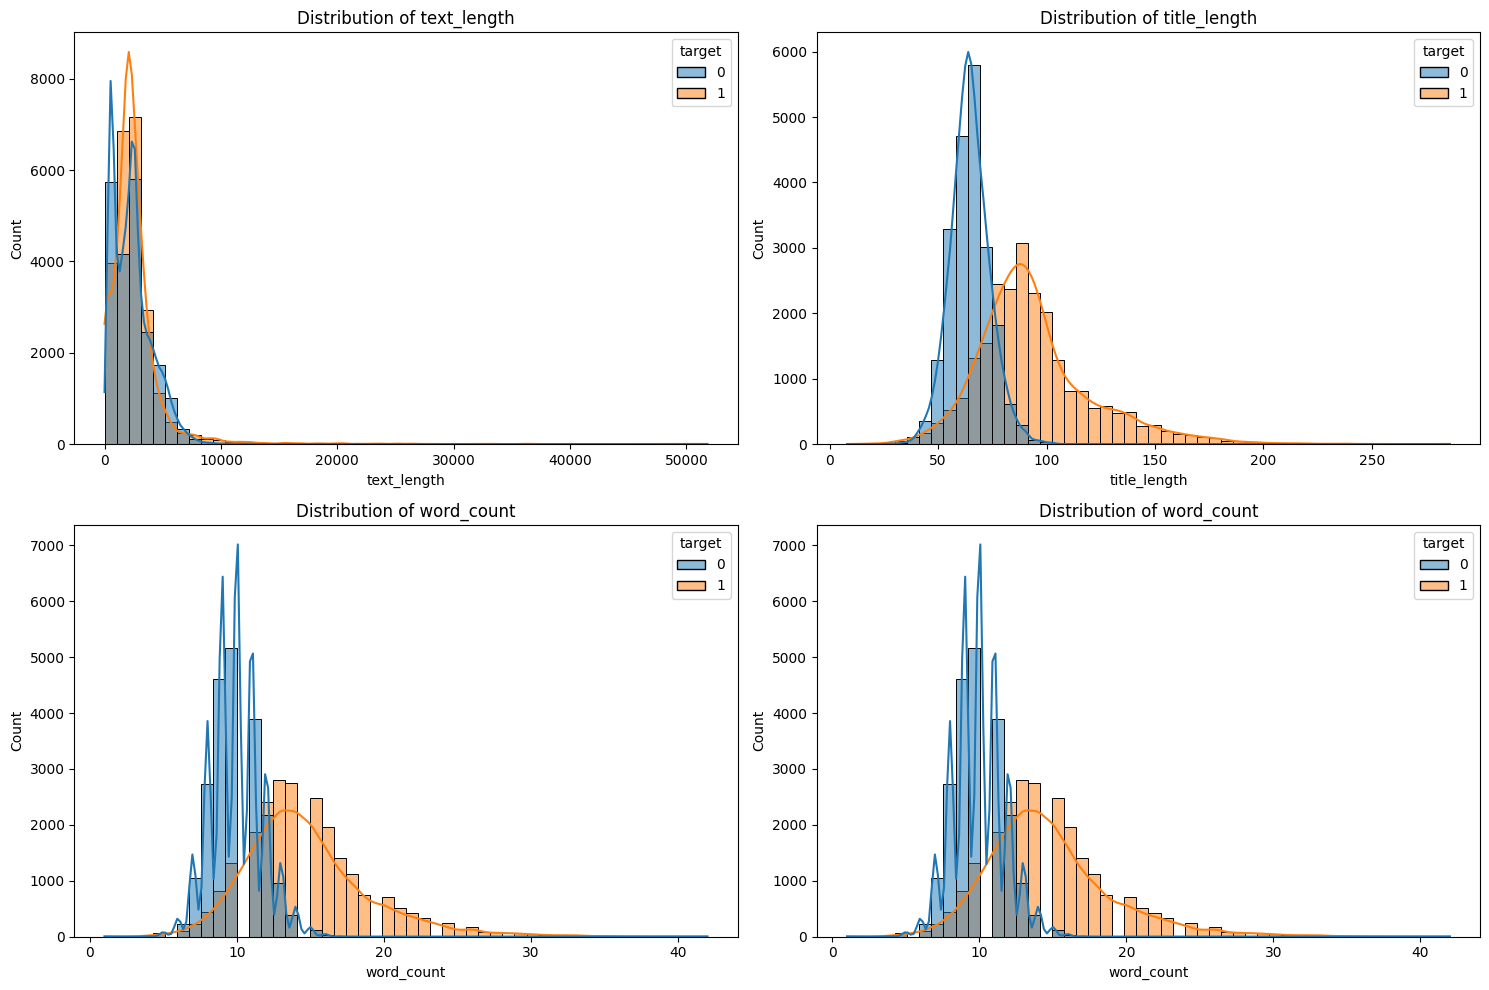

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid

columns = ['text_length', 'title_length', 'word_count', 'word_count']

for ax, col in zip(axes.flat, columns):
    sns.histplot(df_total, x=col, hue='target', bins=50, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

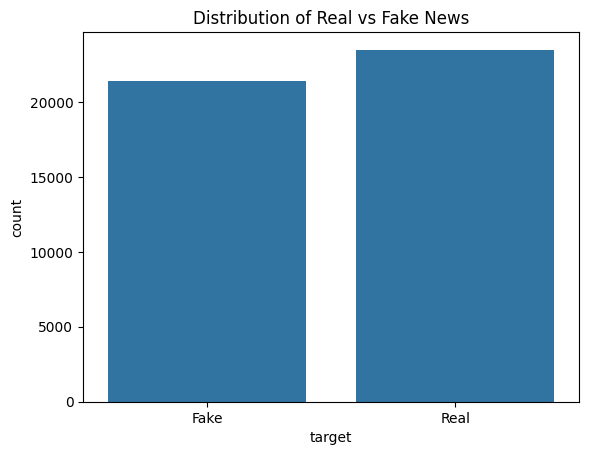

In [ ]:
sns.countplot(data=df_total, x='target')
plt.title("Distribution of Real vs Fake News")
plt.xticks(ticks=[0, 1], labels=["Fake", "Real"])
plt.show()

# Text Processing and Vectorization

## Text processing pipeline
The first task involves preparing and transforming raw news articles into a format suitable for machine learning models. We will implement a complete text preprocessing pipeline, including:
- Tokenization
- Lowercasing
- Removal of stopwords
- Lemmatization or stemming
- Removal of punctuation, special characters, and possibly named entities

For this task, we will use libraries such as SpaCy, NLTK, and scikit-learn to automate and optimize preprocessing.



In this dataset there is a big problem with contractrion and we eill try to see if we can detect the cases of 's in which we should add a ' to be able to fix the contractions.

In [ ]:
nlp = spacy.load("en_core_web_sm")
wnl = WordNetLemmatizer()
broken_contractions = {
    r"\bdon t\b": "don't",
    r"\bwon t\b": "won't",
    r"\bcan t\b": "can't",
    r"\bi m\b": "I'm",
    r"\byou re\b": "you're",
    r"\bhe s\b": "he's",
    r"\bshe s\b": "she's",
    r"\bit s\b": "it's",
    r"\bwe re\b": "we're",
    r"\bthey re\b": "they're",
    r"\bthat s\b": "that's",
    r"\bthere s\b": "there's",
    r"\bwhat s\b": "what's"
}

In [ ]:
def text_preprocessing_pipeline(text):

    text = BeautifulSoup(text, 'lxml').get_text()
    for pattern, replacement in broken_contractions.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)


    text = contractions.fix(text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)

    doc = nlp(text)

    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and token.lemma_.isalpha()
    ]

    tokens = [wnl.lemmatize(token) for token in tokens if token.isalnum()]

    return tokens

In [ ]:
df_total['text'][0]

'Democrats stood up for the American people but Republicans shouted them down and voted to strip health care from millions.Senate Republicans voted to repeal the Affordable Care Act, also known as Obamacare, in the middle of the night early Thursday morning.Even though Republicans don t have any plan to replace it with, they used budget reconciliation rules to prevent Democrats from blocking the vote and took the first step toward ending critical patient and consumer protections Americans have been enjoying for a few years since the Affordable Care Act went into effect, including protections for women, young people, and people with pre-existing conditions.During the roll call vote, Democrats stood up one by one when called to voice their strenuous objections, only to be shouted down by Republicans.Senator Elizabeth Warren can be heard trying to deliver an emotional defense of the landmark healthcare law, but Republicans disrespected her and others by repeatedly declaring them to be out

In [ ]:
" ".join(text_preprocessing_pipeline(df_total['text'][0]))

'democrat stand american people republican shout vote strip health care million senate republican vote repeal affordable care act know obamacare middle night early thursday morning republican plan replace budget reconciliation rule prevent democrat block vote take step end critical patient consumer protection american enjoy year affordable care act go effect include protection woman young people people pre existing condition roll vote democrat stand call voice strenuous objection shout republican senator elizabeth warren hear try deliver emotional defense landmark healthcare law republican disrespect repeatedly declare order republican go pas budget resolution simple majority vote cowardly way possible order american dark s video twitter al franken elizabeth warren parade democrat drown defend obamacare dan diamond january donald trump get elect republican repeal affordable care act priority trump claim prefer replacement ready happen million american suffer heartless action partisan h

In [ ]:
df_total['text_tokens'] = df_total['text'].progress_apply(text_preprocessing_pipeline)
df_total['title_tokens'] = df_total['title'].progress_apply(text_preprocessing_pipeline)

  0%|          | 0/44898 [00:00<?, ?it/s]

<ipython-input-10-033572685101>:3: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(text, 'lxml').get_text()


  0%|          | 0/44898 [00:00<?, ?it/s]

<ipython-input-10-033572685101>:3: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(text, 'lxml').get_text()


Average number of tokens per title: 8.85
Average number of tokens per news: 213.51


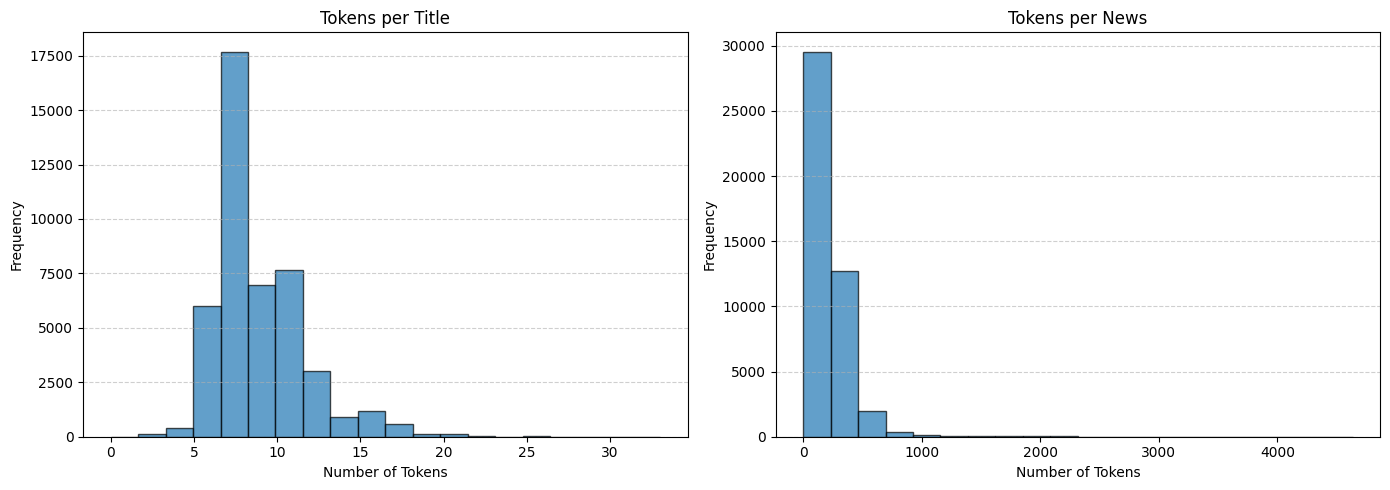

In [ ]:
corpus_title = df_total['title_tokens']
num_tokens_per_title = [len(a) for a in corpus_title]
corpus = df_total['text_tokens']
num_tokens_per_review = [len(a) for a in corpus]
average_tokens_title = np.mean(num_tokens_per_title)
print(f"Average number of tokens per title: {average_tokens_title:.2f}")
average_tokens = np.mean(num_tokens_per_review)
print(f"Average number of tokens per news: {average_tokens:.2f}")


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(num_tokens_per_title, bins=20, edgecolor='black', alpha=0.7)
axes[0].set_title("Tokens per Title")
axes[0].set_xlabel("Number of Tokens")
axes[0].set_ylabel("Frequency")
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

axes[1].hist(num_tokens_per_review, bins=20, edgecolor='black', alpha=0.7)
axes[1].set_title("Tokens per News")
axes[1].set_xlabel("Number of Tokens")
axes[1].set_ylabel("Frequency")
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

We save the created dataset to be able to reuse it without running all the code.

In [2]:
df_total.to_csv('df_total.csv', index=False)

NameError: name 'df_total' is not defined

In [2]:
df_total = pd.read_csv('df_total.csv')
df_total['title_tokens'] = df_total['title_tokens'].apply(ast.literal_eval)
df_total['text_tokens'] = df_total['text_tokens'].apply(ast.literal_eval)

In [3]:
df_total.head()

title  \
0   WATCH: Republicans Disrespectfully Shout Down...   
1  Saudi Arabia says U.N. report on Yemen 'inaccu...   
2   Watch Morning Joe’s Mika DESTROY Paul Ryan Fo...   
3      House Democrats mull Pelosi leadership future   
4  BREAKING: MI Court Of Appeals Orders Vote Reco...   

                                                text  target  text_length  \
0  Democrats stood up for the American people but...       1         2214   
1  UNITED NATIONS (Reuters) - Saudi Arabia on Fri...       0         2531   
2  Republican House Speaker Paul Ryan has been ge...       1         2107   
3  WASHINGTON (Reuters) - U.S. House Democratic L...       0         3778   
4  The Michigan Court of Appeals rejected Green P...       1         4473   

   title_length  word_count  \
0           106         354   
1            66         396   
2            86         381   
3            45         618   
4           119         745   

                                         text_tokens  \
0  [democrat, stand, american, people, republican...   
1  [united, nation, reuters, saudi, arabia, frida...   
2  [republican, house, speaker, paul, ryan, getti...   
3  [washington, reuters, house, democratic, leade...   
4  [michigan, court, appeal, reject, green, party...   

                                        title_tokens  word_count_title  
0  [watch, republican, disrespectfully, shout, el...                14  
1  [saudi, arabia, say, report, yemen, inaccurate...                10  
2  [watch, morning, joe, mika, destroy, paul, rya...                14  
3  [house, democrat, mull, pelosi, leadership, fu...                 6  
4  [breaking, mi, court, appeal, order, vote, rec...                19

It is important to detect N gramns in this case we will  take groups of two words this could be very interesting for example for names Like Donald Trump or Hilary Clinton.

Then to frequent word and not frequent ones will also be removed, finally we will have a cleaned corpus and dictionarry for vectorization. All this is done diferently for titles and texts.

In [4]:
from gensim.models.phrases import Phrases

phrase_model = Phrases((df_total['text_tokens']), min_count=2, threshold=20)
corpus = [el for el in phrase_model[df_total['text_tokens']]]
df_total['clean_text'] = corpus

phrase_model = Phrases(df_total['title_tokens'], min_count=2, threshold=20)
corpus = [el for el in phrase_model[df_total['title_tokens']]]
df_total['clean_title'] = corpus


Dictionary creation for title and text

In [5]:
title_dictionary = Dictionary(df_total['clean_title'])
text_dictionary = Dictionary(df_total['clean_text'])

# Eliminar palabras poco frecuentes (con un umbral de frecuencia)
title_dictionary.filter_extremes(no_below=2, no_above=0.7)
text_dictionary.filter_extremes(no_below=2, no_above=0.7)

print("Title Dictionary:")
print(title_dictionary.token2id)

print("Text Dictionary:")
print(text_dictionary.token2id)

Title Dictionary:
{'elizabeth_warren': 0, 'late_night': 1, 'repeal_obamacare': 2, 'republican': 3, 'shout': 4, 'vote': 5, 'watch': 6, 'inaccurate': 7, 'misleading': 8, 'report': 9, 'saudi_arabia': 10, 'say': 11, 'yemen': 12, 'destroy': 13, 'endorsing': 14, 'mika': 15, 'morning_joe': 16, 'paul_ryan': 17, 'sell': 18, 'trump': 19, 'video': 20, 'democrat': 21, 'future': 22, 'house': 23, 'leadership': 24, 'mull': 25, 'pelosi': 26, 'activist': 27, 'appeal': 28, 'attorney': 29, 'breaking': 30, 'count': 31, 'court': 32, 'jill_stein': 33, 'mi': 34, 'order': 35, 'stop': 36, 'vote_recount': 37, 'live': 38, 'nation': 39, 'news': 40, 'popular': 41, 'publishes_list': 42, 'refugee': 43, 'want': 44, 'world': 45, 'broach': 46, 'human_right': 47, 'meet': 48, 'obama': 49, 'philippine_duterte': 50, 'anti': 51, 'decision': 52, 'government': 53, 'missile_system': 54, 'south_korean': 55, 'appear': 56, 'fundraiser': 57, 'hillary_clinton': 58, 'los_angeles': 59, 'street_art': 60, 'advisory_council': 61, 'propo

In [6]:
df_total_aux = df_total.copy()
df_total = df_total.iloc[:1000]
df_total.shape

(1000, 11)

In [7]:
corpus_def = []
for sent in df_total['clean_text']:
  aux = [token for token in sent if token in text_dictionary.token2id.keys()]
  corpus_def.append(aux)

df_total['clean_text'] = corpus_def

corpus_def = []
for sent in df_total['clean_title']:
  aux = [token for token in sent if token in text_dictionary.token2id.keys()]
  corpus_def.append(aux)

df_total['clean_title'] = corpus_def

<ipython-input-7-e7821141d34e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['clean_text'] = corpus_def
<ipython-input-7-e7821141d34e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['clean_title'] = corpus_def


### Vectorisation

1. Bag of words vectorizatiom

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Convert the list of tokens in each row to a single string before joining
X_bow = [text_dictionary.doc2bow(text) for text in df_total['clean_text']]
X_bow_title =  [title_dictionary.doc2bow(text) for text in df_total['clean_title']]

2. TFIDF vectorization

In [9]:
from gensim.models import TfidfModel

tfidf_model = TfidfModel(X_bow)
text_corpus_tfidf = tfidf_model[X_bow]

tfidf_model_title = TfidfModel(X_bow_title)
title_corpus_tfidf = tfidf_model_title[X_bow_title]


4. Doc2Vec Vectorization

In [10]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Usar directamente los tokens preprocesados
text_documents = [TaggedDocument(words=tokens, tags=[f"text_{i}"]) for i, tokens in enumerate(df_total['clean_text'])]
title_documents = [TaggedDocument(words=tokens, tags=[f"title_{i}"]) for i, tokens in enumerate(df_total['clean_title'])]

# Entrenar modelo Doc2Vec para textos
doc2vec_model_text = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=20)
doc2vec_model_text.build_vocab(text_documents)
doc2vec_model_text.train(text_documents, total_examples=doc2vec_model_text.corpus_count, epochs=doc2vec_model_text.epochs)

# Entrenar modelo Doc2Vec para títulos
doc2vec_model_title = Doc2Vec(vector_size=50, window=3, min_count=2, workers=4, epochs=20)
doc2vec_model_title.build_vocab(title_documents)
doc2vec_model_title.train(title_documents, total_examples=doc2vec_model_title.corpus_count, epochs=doc2vec_model_title.epochs)

# Inferir vectores para cada documento
text_doc_vectors = [doc2vec_model_text.infer_vector(tokens) for tokens in df_total['clean_text']]
title_doc_vectors = [doc2vec_model_title.infer_vector(tokens) for tokens in df_total['clean_title']]

# Convertir a DataFrames para análisis o modelado
import pandas as pd
doc2vec_text_df = pd.DataFrame(text_doc_vectors).add_prefix("text_d2v_")
doc2vec_title_df = pd.DataFrame(title_doc_vectors).add_prefix("title_d2v_")

# Unir a tu dataset original si lo necesitas
#df_total = pd.concat([df_total.reset_index(drop=True), doc2vec_text_df, doc2vec_title_df], axis=1)

print("Doc2Vec vectorization completa. Nuevas columnas añadidas al DataFrame.")



Doc2Vec vectorization completa. Nuevas columnas añadidas al DataFrame.


In [11]:
import gensim
import numpy as np
import gensim.downloader as api
from sklearn.preprocessing import normalize

glove_model = api.load("glove-wiki-gigaword-50")



def get_doc_vector(tokens):
    vectors = [glove_model[word] for word in tokens if word in glove_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(glove_model.vector_size)

# Obtener los vectores de GloVe para los títulos y textos
X_glove = np.vstack(df_total['clean_text'].progress_apply(get_doc_vector))
X_glove = normalize(X_glove)

X_glove_titles = np.vstack(df_total['clean_title'].progress_apply(get_doc_vector))
X_glove_titles = normalize(X_glove_titles)

print("GloVe Vectors for Titles:")
print(X_glove_titles)

print("GloVe Vectors for Texts:")
print(X_glove)


[==================================================] 100.0% 66.0/66.0MB downloaded


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

GloVe Vectors for Titles:
[[-0.0984306  -0.12210929  0.14841092 ... -0.04739055 -0.0193666
   0.0929658 ]
 [ 0.09428259 -0.21684613  0.07049971 ...  0.43056628  0.24770486
  -0.00795202]
 [ 0.04191677 -0.02812768  0.2252428  ... -0.02278147 -0.00981249
   0.03783484]
 ...
 [-0.1246494  -0.04404839 -0.01603226 ...  0.19592184 -0.03461692
   0.10347275]
 [ 0.21625628  0.08904993  0.11841447 ...  0.27940708 -0.27705788
   0.07054243]
 [ 0.05348916 -0.10651506 -0.10461035 ...  0.04939139 -0.02475584
   0.07015785]]
GloVe Vectors for Texts:
[[ 0.00799126 -0.00586311  0.05297413 ... -0.00623575  0.00169699
   0.09286669]
 [ 0.09855698 -0.01901957  0.06494935 ...  0.1278189   0.00729625
  -0.0243985 ]
 [-0.01441485  0.06627481  0.05582388 ...  0.04609807  0.03821268
   0.10962732]
 ...
 [ 0.03081772  0.04285739  0.04853196 ...  0.12807272  0.014954
   0.07681492]
 [ 0.10696294  0.07188512  0.03484274 ...  0.15036167 -0.08285035
  -0.0313235 ]
 [ 0.019875    0.05837696  0.00979816 ...  0.09263

lda anlysis

In [12]:
from gensim.models import CoherenceModel, LdaModel

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                                id2word=dictionary,
                                num_topics=num_topics,
                                random_state=42,
                                passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Define range of topics
start = 4
limit = 15
step = 2


# Compute coherence for BoW
lda_models_bow, coherence_bow = compute_coherence_values(dictionary=text_dictionary,
                                                         corpus=X_bow,
                                                         start=start,
                                                         limit=limit,
                                                         step=step,
                                                         texts=df_total['clean_text'])

# Compute coherence for TF-IDF
lda_models_tfidf, coherence_tfidf = compute_coherence_values(dictionary=text_dictionary,
                                                             corpus=text_corpus_tfidf,
                                                             start=start,
                                                             limit=limit,
                                                             step=step,
                                                             texts=df_total['clean_text'])

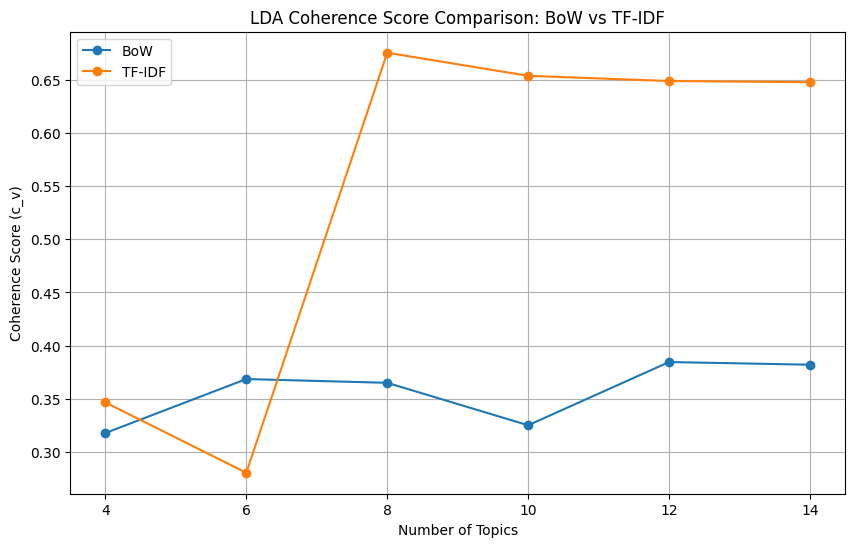

In [13]:
x = range(start, limit, step)
plt.figure(figsize=(10, 6))
plt.plot(x, coherence_bow, label="BoW", marker='o')
plt.plot(x, coherence_tfidf, label="TF-IDF", marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.legend()
plt.title("LDA Coherence Score Comparison: BoW vs TF-IDF")
plt.grid(True)
plt.show()

In [14]:
best_idx = coherence_tfidf.index(max(coherence_tfidf))  # or coherence_tfidf
best_model = lda_models_bow[best_idx]  # or lda_models_tfidf[best_idx]

best_model.print_topics(num_words=10)


[(0,
  '0.006*"s" + 0.004*"police" + 0.003*"state" + 0.002*"time" + 0.002*"group" + 0.002*"student" + 0.002*"take" + 0.001*"cop" + 0.001*"article" + 0.001*"officer"'),
 (1,
  '0.016*"trump" + 0.015*"s" + 0.006*"people" + 0.006*"president" + 0.005*"republican" + 0.004*"state" + 0.004*"country" + 0.004*"year" + 0.004*"donald_trump" + 0.004*"tell"'),
 (2,
  '0.013*"s" + 0.003*"people" + 0.003*"party" + 0.003*"like" + 0.003*"republican" + 0.002*"year" + 0.002*"conservative" + 0.002*"want" + 0.002*"president" + 0.002*"tell"'),
 (3,
  '0.001*"energy" + 0.001*"gun" + 0.001*"school" + 0.001*"tribe" + 0.001*"schumer" + 0.001*"pakistan" + 0.001*"williams" + 0.001*"isaac" + 0.001*"sinai" + 0.001*"company"'),
 (4,
  '0.003*"s" + 0.001*"police" + 0.001*"soros" + 0.001*"castro" + 0.001*"hollywood" + 0.001*"kill" + 0.001*"report" + 0.001*"accord" + 0.001*"prince" + 0.001*"year"'),
 (5,
  '0.002*"percent" + 0.002*"gain" + 0.002*"billion" + 0.001*"tax" + 0.001*"party" + 0.001*"italy" + 0.001*"technolog

In [15]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(best_model, text_corpus_tfidf, text_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.273120  0.008434       1        1  60.217640
2     -0.089086 -0.060592       2        1  12.805463
0     -0.016713  0.069845       3        1   7.289079
6      0.046082 -0.001178       4        1   4.722295
4      0.060342 -0.010920       5        1   4.479545
7      0.062346  0.013850       6        1   4.322276
3      0.090285 -0.008547       7        1   3.540836
5      0.119864 -0.010893       8        1   2.622866, topic_info=        Term       Freq      Total Category  logprob  loglift
91         s  97.000000  97.000000  Default  30.0000  30.0000
103    trump  82.000000  82.000000  Default  29.0000  29.0000
555  percent   9.000000   9.000000  Default  28.0000  28.0000
875   police   7.000000   7.000000  Default  27.0000  27.0000
203   report  17.000000  17.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
811    local   0.088231   4.048398   Topic8  -7.8069  -0.1852
854  foreign   0.082864   4.621196   Topic8  -7.8697  -0.3803
91         s   0.095799  97.711371   Topic8  -7.7246  -3.2866
583    state   0.086509  26.734028   Topic8  -7.8266  -2.0925
636  migrant   0.076860   2.130909   Topic8  -7.9449   0.3186

[568 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
2811      1  0.785307        abortion
324       1  0.863629          accord
324       2  0.086363          accord
1105      1  0.903771  administration
3281      1  1.166003      ambassador
...     ...       ...             ...
112       1  0.839396            year
112       2  0.079942            year
112       3  0.039971            year
1759      1  0.680863        year_old
1759      2  0.226954        year_old

[316 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 7, 5, 8, 4, 6])

In [16]:
from gensim.matutils import corpus2dense
from sklearn.metrics.pairwise import cosine_similarity
# Assuming num_terms is the total number of terms in your dictionary
num_terms = len(text_dictionary)

# Convert X_bow to a dense NumPy array
X_bow_dense = corpus2dense(X_bow, num_terms=num_terms).T

# Convert X_bow_title to a dense NumPy array
num_terms_title = len(title_dictionary)
X_bow_title_dense = corpus2dense(X_bow_title, num_terms=num_terms_title).T

# Now you can use cosine_similarity:
similarity_bow = cosine_similarity(X_bow_dense)
similarity_bow_title = cosine_similarity(X_bow_title_dense)

num_terms_text = len(text_dictionary)
X_tfidf_dense = corpus2dense(text_corpus_tfidf, num_terms=num_terms_text).T
similarity_tfidf = cosine_similarity(X_tfidf_dense)

# Para los títulos
num_terms_title = len(title_dictionary)
X_tfidf_title_dense = corpus2dense(title_corpus_tfidf, num_terms=num_terms_title).T
similarity_tfidf_title = cosine_similarity(X_tfidf_title_dense)

## Comparison of Vectorisation techniques

All the tested Vectorization techniques are checked and compared throught the similarity matrix. We can say teh for titles Doc"Vect is the first one and GloVe is the best one for texts.

In [17]:
def average_similarity(matrix):
    n = matrix.shape[0]
    return (matrix.sum() - n) / (n * (n - 1))

In [18]:


similarity_doc2vec_text = cosine_similarity(text_doc_vectors)
similarity_doc2vec_titles = cosine_similarity(title_doc_vectors)
similarity_glove_titles = cosine_similarity(X_glove_titles)
similarity_glove_texts = cosine_similarity(X_glove)


print("Cosine Similarity Matrix (BoW - Text):")
print(average_similarity(similarity_bow))

print("\nCosine Similarity Matrix (BoW - Title):")
print(average_similarity(similarity_bow_title))

print("\nCosine Similarity Matrix (TF-IDF - Text):")
print(average_similarity(similarity_tfidf))

print("\nCosine Similarity Matrix (TF-IDF - Title):")
print(average_similarity(similarity_tfidf_title))

print("\nCosine Similarity Matrix (Doc2Vec - Text):")
print(average_similarity(similarity_doc2vec_text))
print("\nCosine Similarity Matrix (Doc2Vec - Title):")
print(average_similarity(similarity_doc2vec_titles))

print("\nCosine Similarity Matrix (GloVe - Text):")
print(average_similarity(similarity_glove_texts))

print("\nCosine Similarity Matrix (GloVe - Title):")
print(average_similarity(similarity_glove_titles))


Cosine Similarity Matrix (BoW - Text):
0.08275214276776777

Cosine Similarity Matrix (BoW - Title):
0.027304362956706706

Cosine Similarity Matrix (TF-IDF - Text):
0.016953381115490492

Cosine Similarity Matrix (TF-IDF - Title):
0.004981607584146647

Cosine Similarity Matrix (Doc2Vec - Text):
0.28402402402402405

Cosine Similarity Matrix (Doc2Vec - Title):
0.9367481856856856

Cosine Similarity Matrix (GloVe - Text):
0.862156874216699

Cosine Similarity Matrix (GloVe - Title):
0.6419368496948761


In [19]:
df_total = df_total_aux
df_total.shape

(44898, 11)

In [20]:
def get_doc_vector(tokens):
    vectors = [glove_model[word] for word in tokens if word in glove_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(glove_model.vector_size)

# Obtener los vectores de GloVe para los títulos y textos
X_glove = np.vstack(df_total['clean_text'].progress_apply(get_doc_vector))
X_glove = normalize(X_glove)

print("GloVe Vectors for Texts:")
print(X_glove)

  0%|          | 0/44898 [00:00<?, ?it/s]

GloVe Vectors for Texts:
[[ 0.00799126 -0.00586311  0.05297413 ... -0.00623575  0.00169699
   0.09286669]
 [ 0.09914109 -0.02033434  0.06712026 ...  0.12862684  0.00614977
  -0.02222128]
 [-0.00971081  0.06145255  0.05920604 ...  0.05002492  0.03550326
   0.10809707]
 ...
 [ 0.00464783 -0.01760152  0.07658307 ...  0.08545092 -0.00150427
   0.10985834]
 [ 0.00059154  0.05097274  0.01642723 ...  0.06795161  0.04957556
  -0.00406017]
 [ 0.01334794 -0.0030694   0.0529456  ...  0.04247991 -0.01306431
   0.06950811]]


In [21]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument


title_documents = [TaggedDocument(words=tokens, tags=[f"title_{i}"]) for i, tokens in enumerate(df_total['clean_title'])]


# Entrenar modelo Doc2Vec para títulos
doc2vec_model_title = Doc2Vec(vector_size=50, window=3, min_count=2, workers=4, epochs=20)
doc2vec_model_title.build_vocab(title_documents)
doc2vec_model_title.train(title_documents, total_examples=doc2vec_model_title.corpus_count, epochs=doc2vec_model_title.epochs)


title_doc_vectors = [doc2vec_model_title.infer_vector(tokens) for tokens in df_total['clean_title']]
doc2vec_title_df = pd.DataFrame(title_doc_vectors).add_prefix("title_d2v_")

print("Doc2Vec vectorization completa. Nuevas columnas añadidas al DataFrame.")

Doc2Vec vectorization completa. Nuevas columnas añadidas al DataFrame.


### TASK 2: Classification

1. BenchMarck using Metadat about the news

2. Iteration over title information models

3. Iteration with corpus information

4. Best model selection

1. Bench Marck using Metadata

Classification Report (Linear Regression with Macro Data):
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      4261
           1       0.88      0.81      0.84      4719

    accuracy                           0.84      8980
   macro avg       0.84      0.84      0.84      8980
weighted avg       0.85      0.84      0.84      8980



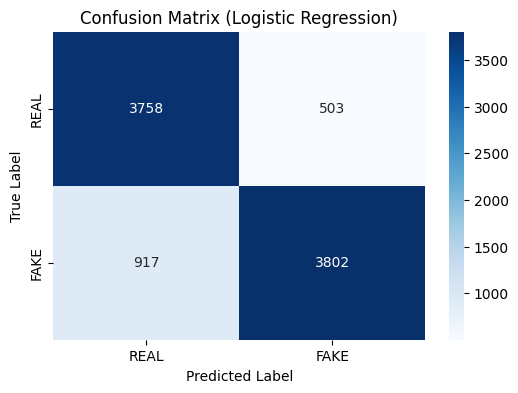

In [22]:
X = df_total[['title_length', 'word_count','text_length', 'word_count_title']]
y = df_total['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión logística
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = lr_model.predict(X_test)
print("Classification Report (Linear Regression with Macro Data):")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()


2. Model using only the title text


Logistic Regression (Using Title):
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4261
           1       0.87      0.86      0.86      4719

    accuracy                           0.86      8980
   macro avg       0.86      0.86      0.86      8980
weighted avg       0.86      0.86      0.86      8980


Random Forest (Using Title):
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4261
           1       0.87      0.88      0.87      4719

    accuracy                           0.87      8980
   macro avg       0.87      0.87      0.87      8980
weighted avg       0.87      0.87      0.87      8980


SVM (Using Title):
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4261
           1       0.91      0.89      0.90      4719

    accuracy                           0.89      8980
   macro avg       0.89      0.89      0.8

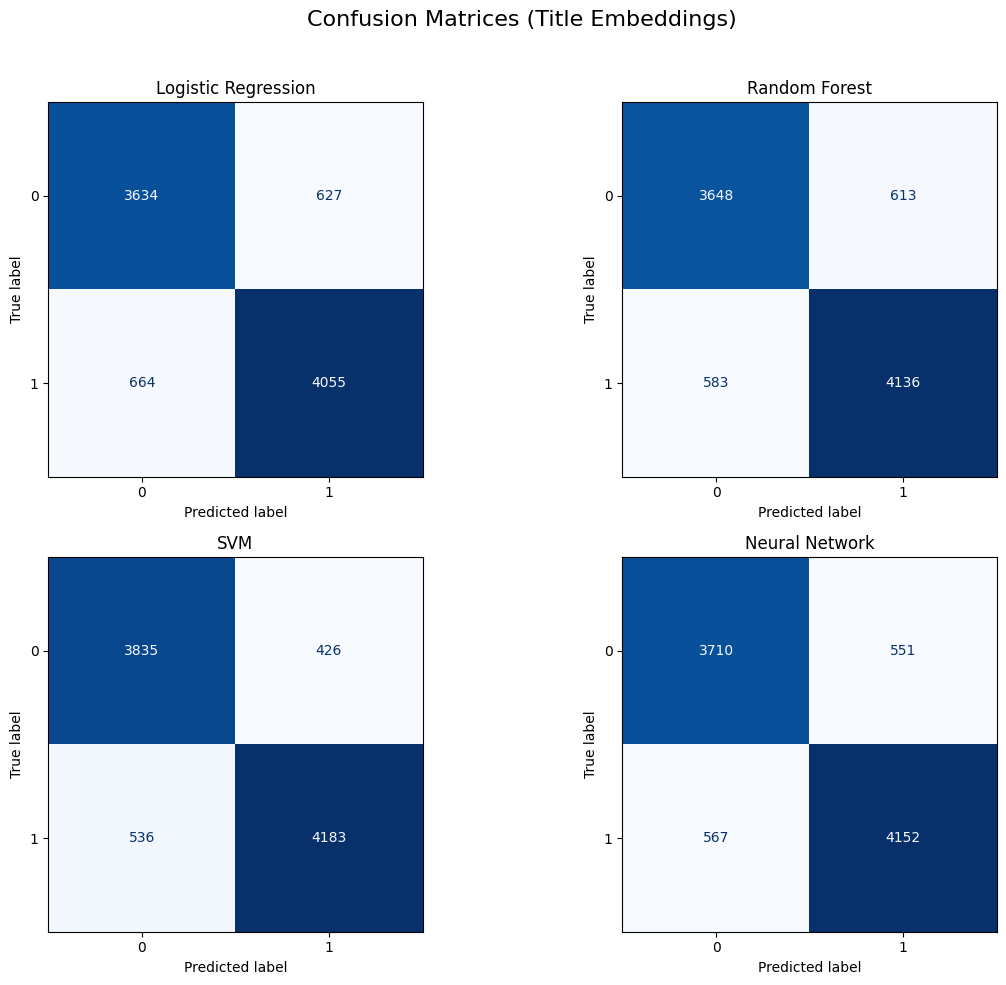

In [23]:
X_title = title_doc_vectors

X_train, X_test, y_train, y_test = train_test_split(X_title, y, test_size=0.2, random_state=42)

# Modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

# Crear subplots (2 filas x 2 columnas)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()  # Aplanar para indexar fácilmente

# Entrenar y graficar
for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} (Using Title):")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(name)

plt.suptitle("Confusion Matrices (Title Embeddings)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Deja espacio para el título principal
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits

SVM (Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4261
           1       0.88      0.86      0.87      4719

    accuracy                           0.87      8980
   macro avg       0.86      0.87      0.86      8980
weighted avg       0.87      0.87      0.87      8980


Neural Network (Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      4261
           1       0.87      0.86      0.87      4719

    accuracy                           0.86      8980
   macro avg       0.86      0.86      0.86      8980
weighted avg       0.86      0.86      0.86      8980



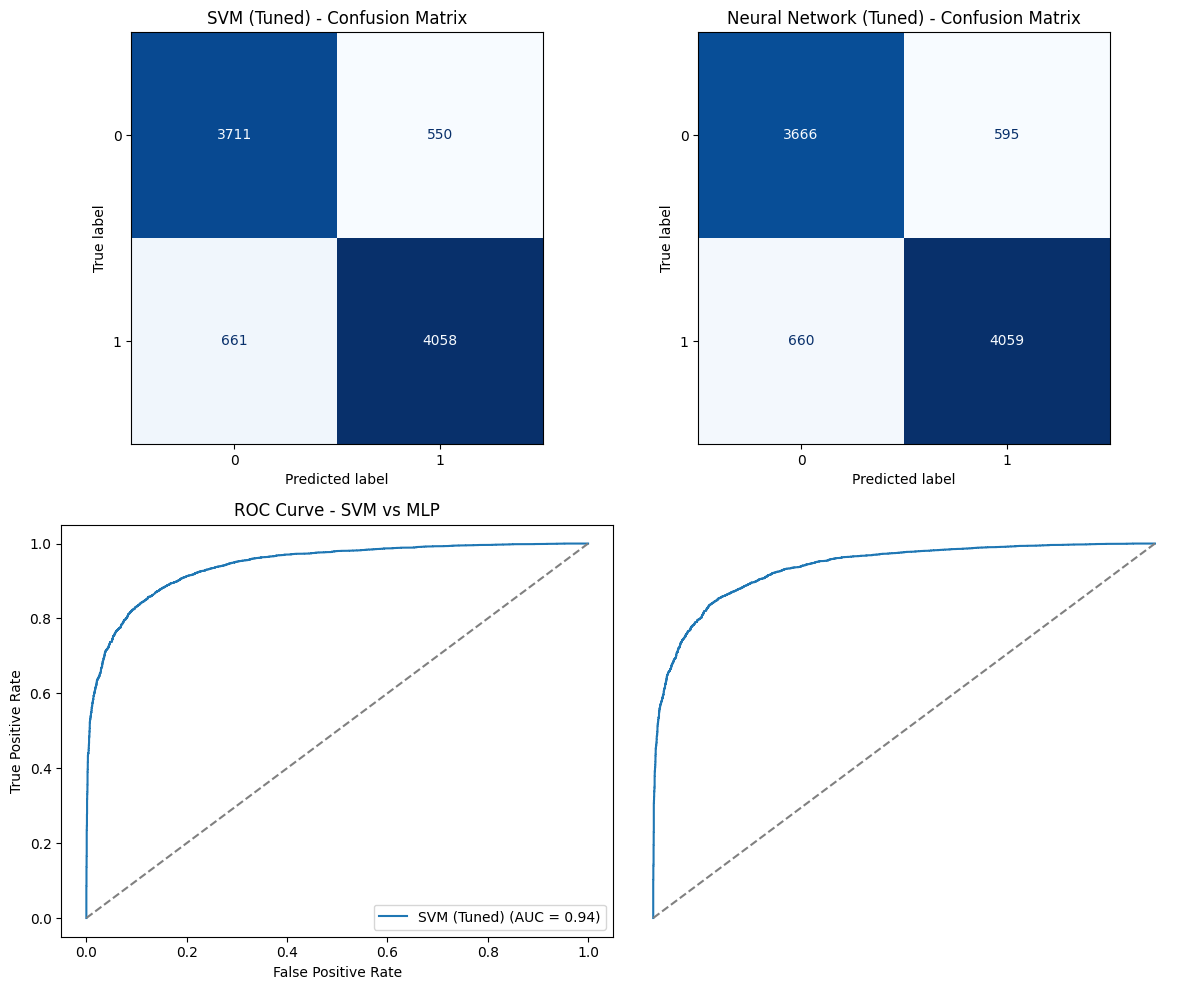


Best parameters (SVM): {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}
Best parameters (MLP): {'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'relu'}


In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train_full, X_test, y_train_full, y_test = train_test_split(X_title, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}
svm = SVC(probability=True)
grid_svm = RandomizedSearchCV(svm, param_grid_svm, cv=5, scoring='roc_auc', n_jobs=-1,n_iter = 10, verbose=2)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (50, 50, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive', 'invscaling']
}
mlp = MLPClassifier(max_iter=1000, random_state=42)
grid_mlp = RandomizedSearchCV(mlp, param_grid_mlp, cv=5, scoring='roc_auc', n_jobs=-1,n_iter = 2,verbose=2)
grid_mlp.fit(X_train, y_train)
best_mlp = grid_mlp.best_estimator_

models = {
    "SVM (Tuned)": best_svm,
    "Neural Network (Tuned)": best_mlp
}


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f"{name} - Confusion Matrix")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    axes[i+2].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    axes[i+2].plot([0, 1], [0, 1], linestyle='--', color='gray')

axes[2].set_title("ROC Curve - SVM vs MLP")
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("True Positive Rate")
axes[2].legend()

axes[3].axis('off')  # Dejar espacio vacío o usar para texto/leyenda

plt.tight_layout()
plt.show()

# Mostrar los mejores parámetros
print("\nBest parameters (SVM):", grid_svm.best_params_)
print("Best parameters (MLP):", grid_mlp.best_params_)

3. Model using the text data


Logistic Regression (Using Text):
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4261
           1       0.90      0.89      0.90      4719

    accuracy                           0.89      8980
   macro avg       0.89      0.89      0.89      8980
weighted avg       0.89      0.89      0.89      8980


Random Forest (Using Text):
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      4261
           1       0.93      0.94      0.93      4719

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980


SVM (Using Text):
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      4261
           1       0.92      0.91      0.91      4719

    accuracy                           0.91      8980
   macro avg       0.91      0.91      0.91  

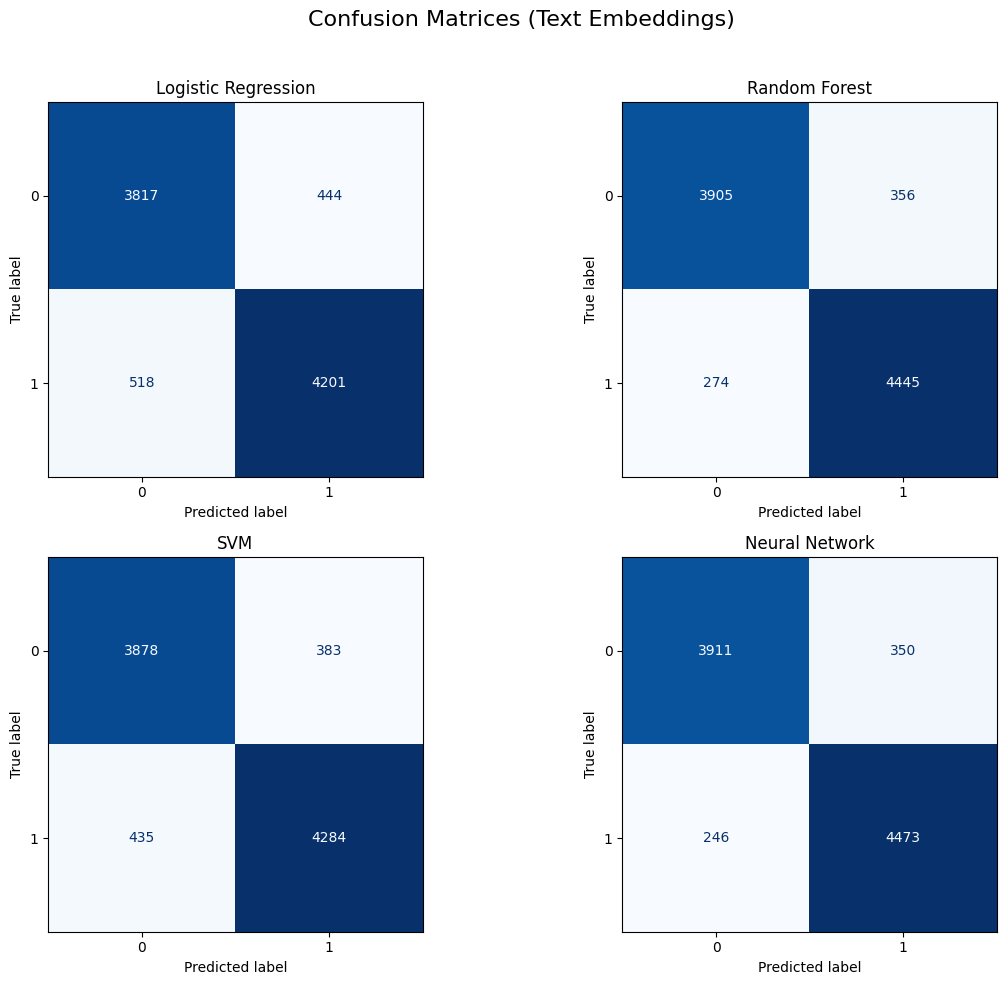

In [25]:
X_title = X_glove

X_train, X_test, y_train, y_test = train_test_split(X_title, y, test_size=0.2, random_state=42)

# Modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

# Crear subplots (2 filas x 2 columnas)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()  # Aplanar para indexar fácilmente

# Entrenar y graficar
for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} (Using Text):")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(name)

plt.suptitle("Confusion Matrices (Text Embeddings)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Deja espacio para el título principal
plt.show()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits

SVM (Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      4261
           1       0.91      0.90      0.90      4719

    accuracy                           0.90      8980
   macro avg       0.90      0.90      0.90      8980
weighted avg       0.90      0.90      0.90      8980


Neural Network (Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4261
           1       0.90      0.90      0.90      4719

    accuracy                           0.89      8980
   macro avg       0.89      0.89      0.89      8980
weighted avg       0.89      0.89      0.89      8980



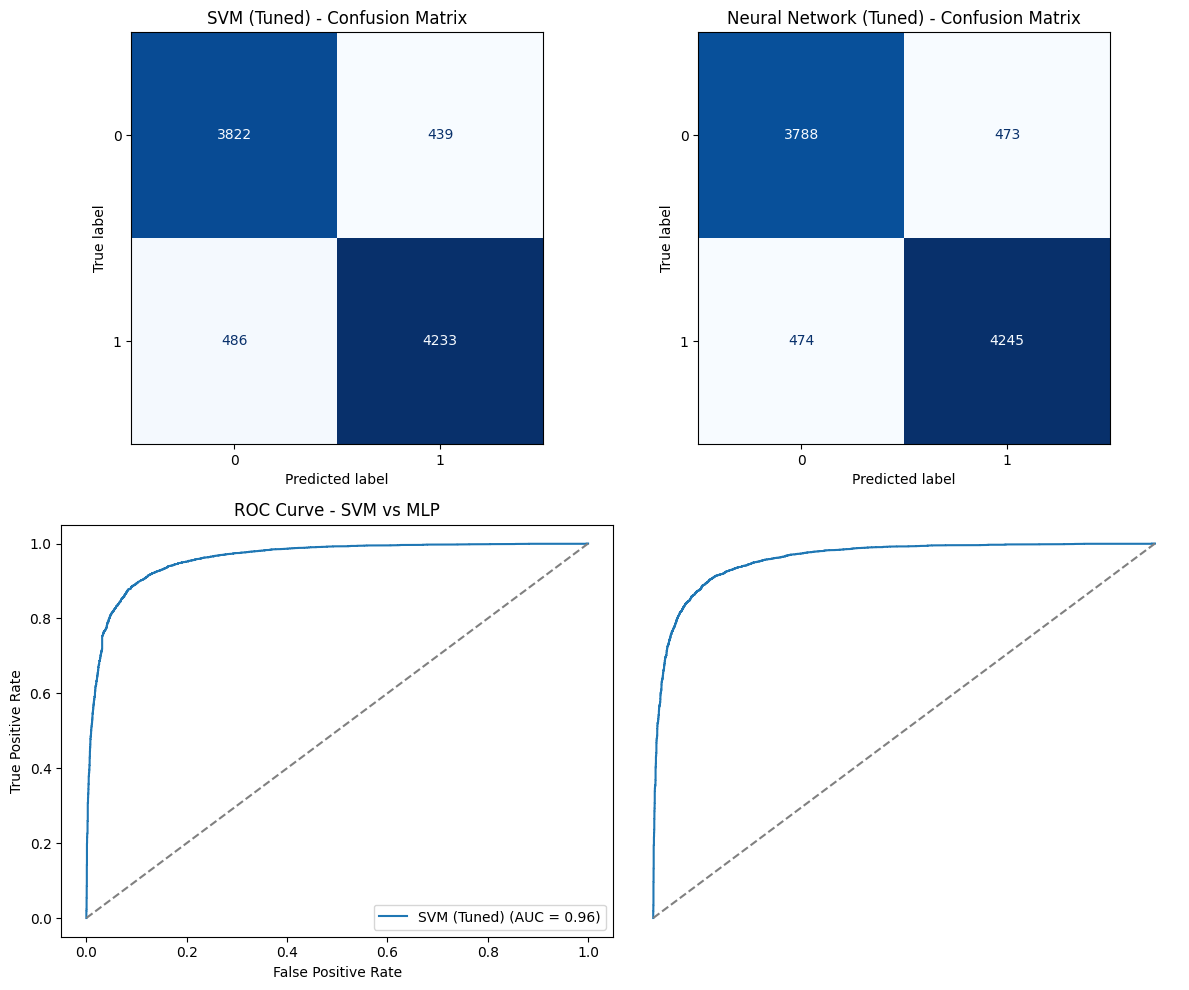


Best parameters (SVM): {'kernel': 'linear', 'gamma': 'auto', 'C': 10}
Best parameters (MLP): {'solver': 'adam', 'learning_rate': 'invscaling', 'hidden_layer_sizes': (50,), 'alpha': 0.01, 'activation': 'logistic'}


In [26]:

X_title = X_glove
X_train_full, X_test, y_train_full, y_test = train_test_split(X_title, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}
svm = SVC(probability=True)
grid_svm =RandomizedSearchCV(svm, param_grid_svm, cv=5, scoring='roc_auc',n_iter = 10, n_jobs=-1,verbose=2)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (50, 50, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive', 'invscaling']
}
mlp = MLPClassifier(max_iter=1000, random_state=42)
grid_mlp = RandomizedSearchCV(mlp, param_grid_mlp, cv=5, scoring='roc_auc', n_iter = 2, n_jobs=-1,verbose=2)
grid_mlp.fit(X_train, y_train)
best_mlp = grid_mlp.best_estimator_

models = {
    "SVM (Tuned)": best_svm,
    "Neural Network (Tuned)": best_mlp
}


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f"{name} - Confusion Matrix")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    axes[i+2].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    axes[i+2].plot([0, 1], [0, 1], linestyle='--', color='gray')

axes[2].set_title("ROC Curve - SVM vs MLP")
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("True Positive Rate")
axes[2].legend()

axes[3].axis('off')  # Dejar espacio vacío o usar para texto/leyenda

plt.tight_layout()
plt.show()

# Mostrar los mejores parámetros
print("\nBest parameters (SVM):", grid_svm.best_params_)
print("Best parameters (MLP):", grid_mlp.best_params_)

In [27]:
X = pd.concat([pd.DataFrame(X_glove), doc2vec_title_df], axis=1)
X.columns = X.columns.astype(str)
X.head()

0         1         2         3         4         5         6  \
0  0.007991 -0.005863  0.052974 -0.065568  0.074188  0.084983 -0.083716   
1  0.099141 -0.020334  0.067120 -0.039127  0.077251  0.019589 -0.041637   
2 -0.009711  0.061453  0.059206 -0.015512  0.112416  0.015976 -0.100046   
3  0.027339  0.019890  0.060272 -0.017482  0.075023  0.039154 -0.113096   
4 -0.009926 -0.050002  0.041375  0.022112  0.044449  0.058920 -0.059726   

          7         8         9  ...  title_d2v_40  title_d2v_41  \
0  0.027354 -0.077355 -0.033190  ...     -0.126149     -0.128521   
1  0.009271  0.054450 -0.054303  ...      0.042145     -0.038944   
2  0.023958 -0.067852  0.014568  ...      0.017419      0.013868   
3  0.044478 -0.089453 -0.090287  ...     -0.008628      0.062461   
4  0.088564 -0.010975 -0.066604  ...      0.050114      0.086947   

   title_d2v_42  title_d2v_43  title_d2v_44  title_d2v_45  title_d2v_46  \
0      0.096206      0.305571     -0.041468     -0.122543      0.036020   
1     -0.083416      0.045544      0.221373     -0.093079      0.009411   
2     -0.063969      0.056020      0.067605     -0.040052     -0.096749   
3     -0.004799      0.091187      0.030301      0.137558      0.019114   
4      0.204981     -0.172834      0.038688     -0.352315      0.190087   

   title_d2v_47  title_d2v_48  title_d2v_49  
0     -0.042976      0.061174      0.092614  
1     -0.152487      0.023192      0.124047  
2      0.020249     -0.061166      0.198889  
3     -0.131270      0.113855     -0.041953  
4     -0.042618      0.303663     -0.141423  

[5 rows x 100 columns]

4. Best model overall


Logistic Regression (Using Text):
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      4261
           1       0.94      0.93      0.93      4719

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980


Random Forest (Using Text):
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      4261
           1       0.93      0.94      0.94      4719

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980


SVM (Using Text):
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      4261
           1       0.96      0.94      0.95      4719

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95  

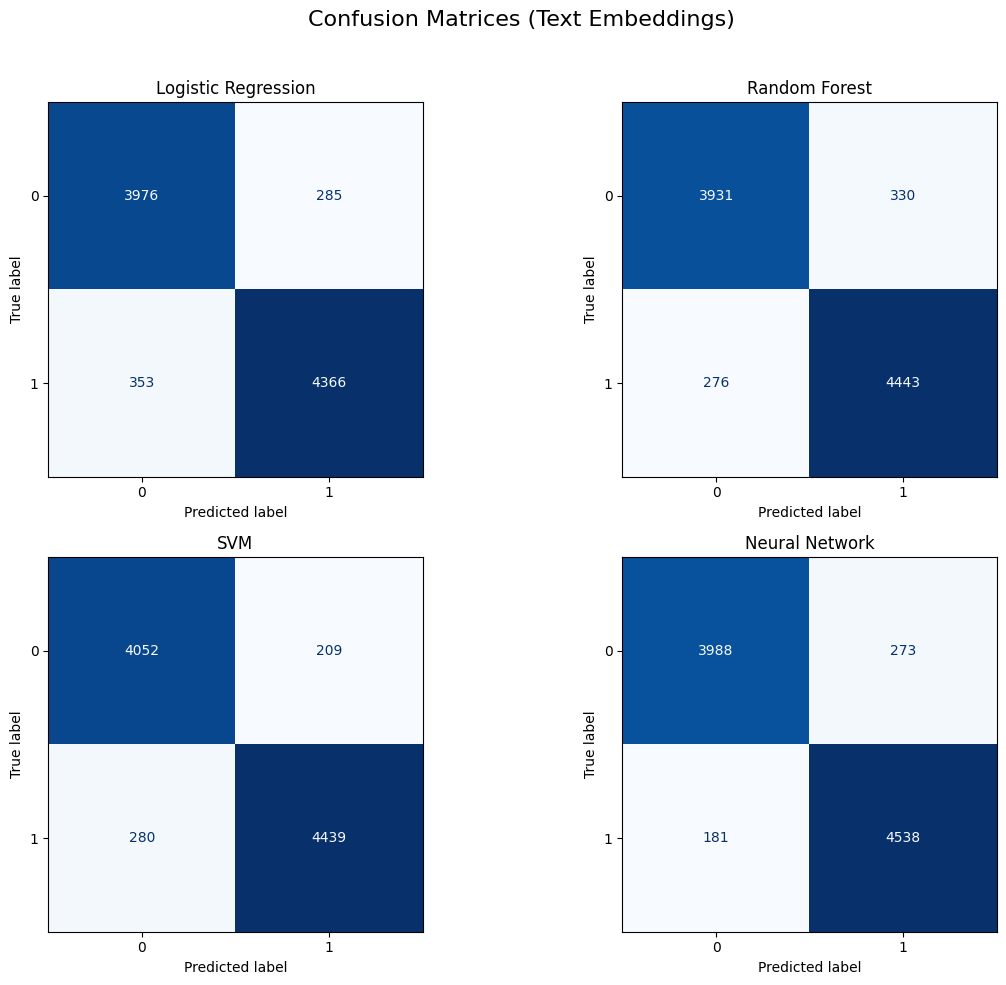

In [28]:

y = df_total['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

# Crear subplots (2 filas x 2 columnas)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()  # Aplanar para indexar fácilmente

# Entrenar y graficar
for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} (Using Text):")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(name)

plt.suptitle("Confusion Matrices (Text Embeddings)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Deja espacio para el título principal
plt.show()

### CLUSTERING

In [29]:
X_titles = title_doc_vectors
X_texts = X_glove
X = X

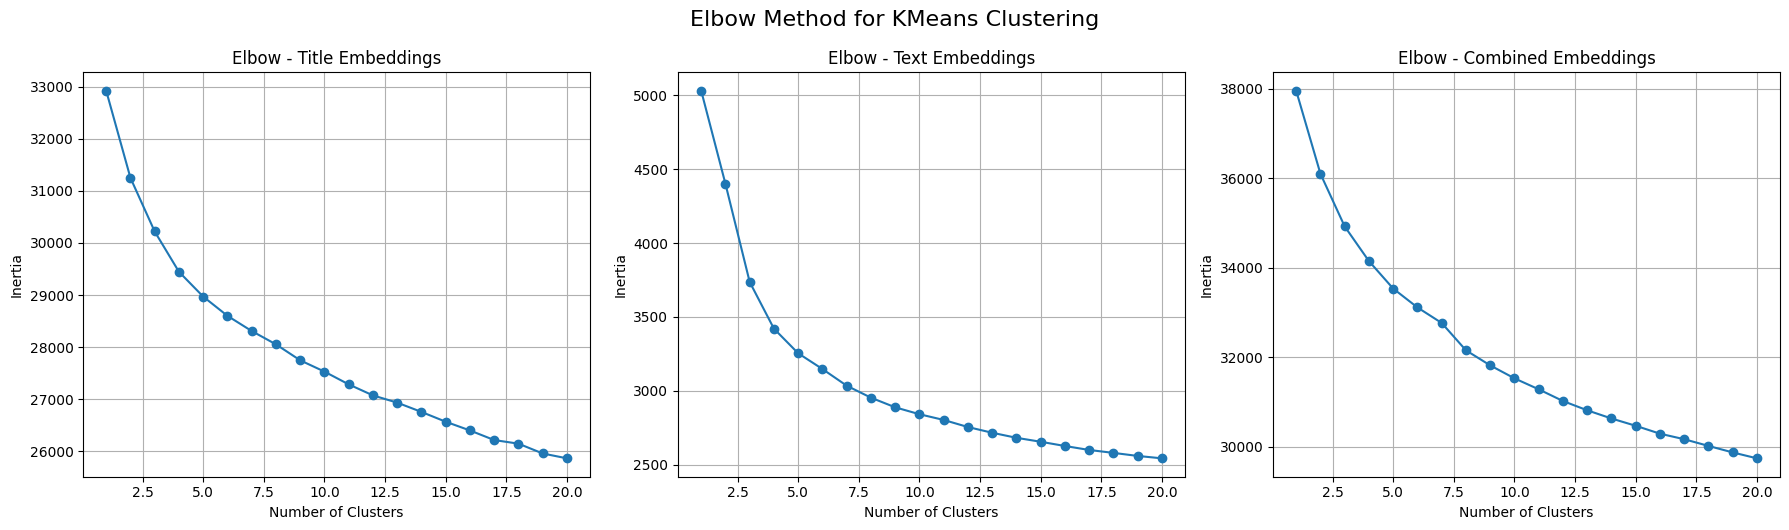

In [30]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




fig, axes = plt.subplots(1, 3, figsize=(18, 5))
max_k = 20

for i, (X_data, name) in enumerate([
    (X_titles, "Title Embeddings"),
    (X_texts, "Text Embeddings"),
    (X, "Combined Embeddings")
]):
    inertias = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_data)
        inertias.append(kmeans.inertia_)

    axes[i].plot(range(1, max_k + 1), inertias, marker='o')
    axes[i].set_title(f'Elbow - {name}')
    axes[i].set_xlabel('Number of Clusters')
    axes[i].set_ylabel('Inertia')
    axes[i].grid(True)

plt.tight_layout()
plt.suptitle("Elbow Method for KMeans Clustering", fontsize=16, y=1.05)
plt.show()


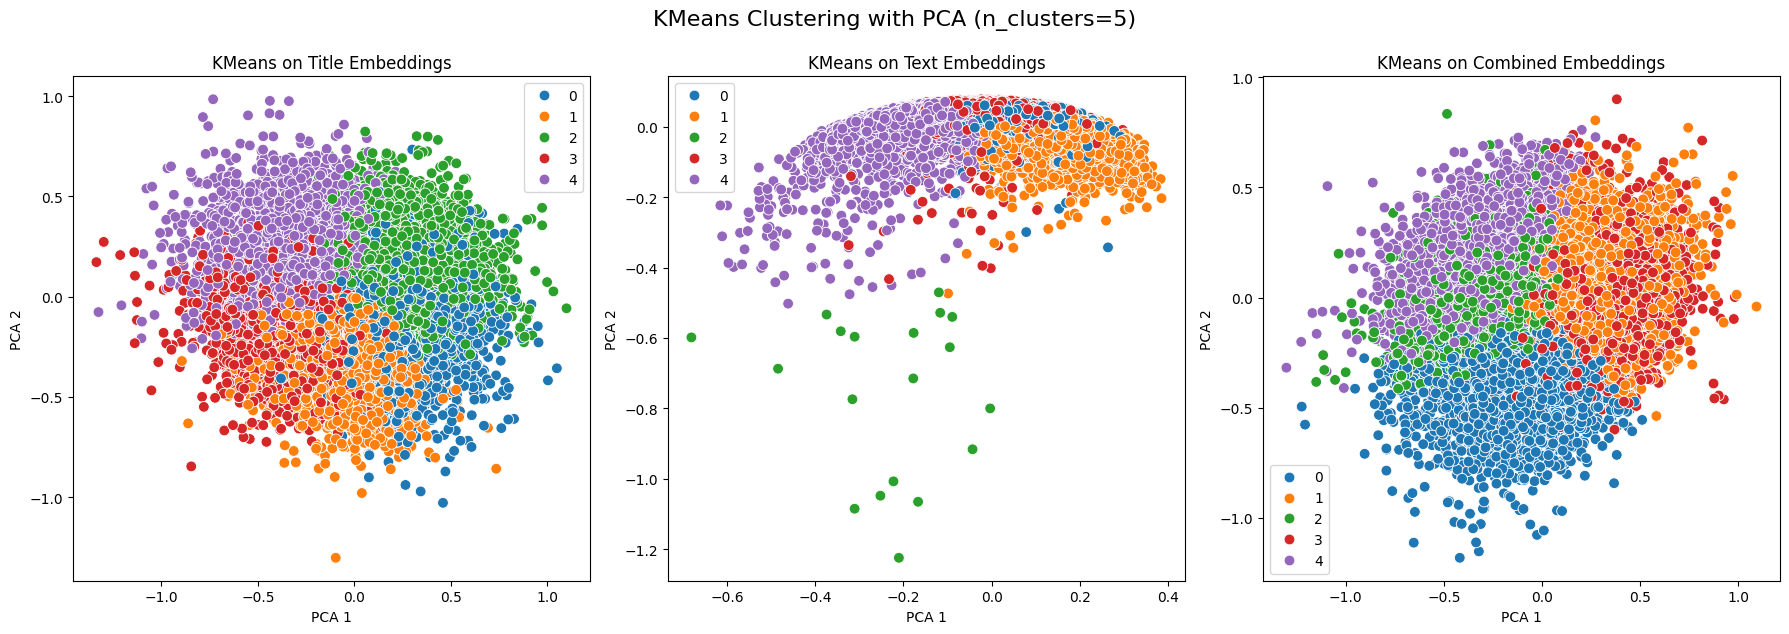

In [31]:
n_clusters = 5


pca_titles = PCA(n_components=2, random_state=42).fit_transform(X_titles)
pca_texts = PCA(n_components=2, random_state=42).fit_transform(X_texts)
pca_combined = PCA(n_components=2, random_state=42).fit_transform(X)

kmeans_titles = KMeans(n_clusters=n_clusters, random_state=42).fit(X_titles)
clusters_titles = kmeans_titles.labels_

kmeans_texts = KMeans(n_clusters=n_clusters, random_state=42).fit(X_texts)
clusters_texts = kmeans_texts.labels_

kmeans_combined = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
clusters_combined = kmeans_combined.labels_


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(x=pca_titles[:, 0], y=pca_titles[:, 1], hue=clusters_titles, palette='tab10', s=60, ax=axes[0])
axes[0].set_title("KMeans on Title Embeddings")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")

sns.scatterplot(x=pca_texts[:, 0], y=pca_texts[:, 1], hue=clusters_texts, palette='tab10', s=60, ax=axes[1])
axes[1].set_title("KMeans on Text Embeddings")
axes[1].set_xlabel("PCA 1")
axes[1].set_ylabel("PCA 2")

sns.scatterplot(x=pca_combined[:, 0], y=pca_combined[:, 1], hue=clusters_combined, palette='tab10', s=60, ax=axes[2])
axes[2].set_title("KMeans on Combined Embeddings")
axes[2].set_xlabel("PCA 1")
axes[2].set_ylabel("PCA 2")

plt.tight_layout()
plt.suptitle(f"KMeans Clustering with PCA (n_clusters={n_clusters})", fontsize=16, y=1.05)
plt.show()


#plot_pca_with_labels(X_titles, y, "Title Embeddings")
#plot_pca_with_labels(X_texts, y, "Text Embeddings")
#plot_pca_with_labels(X, y, "Combined Embeddings")


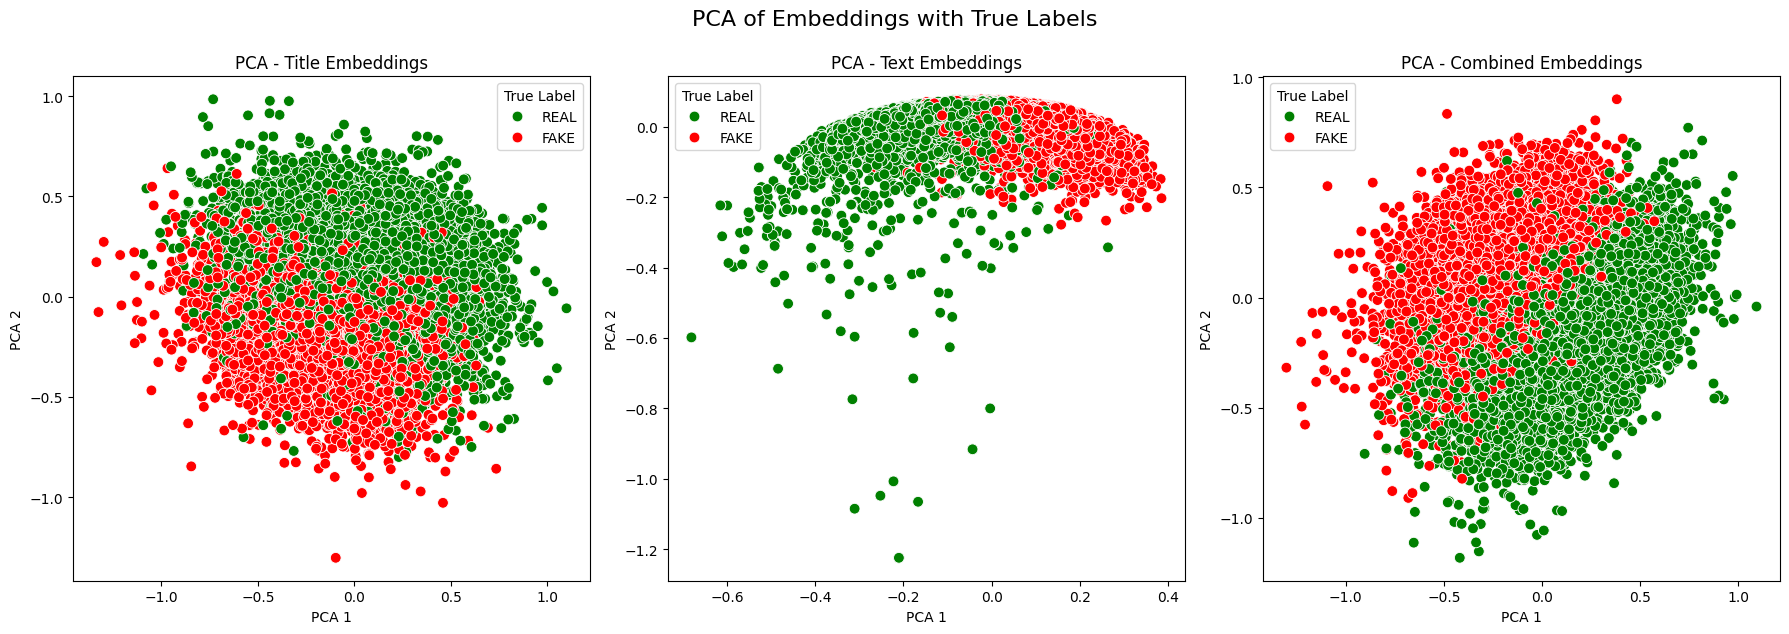

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Etiquetas como texto
y_labels = ['REAL' if label == 1 else 'FAKE' for label in y]
palette = {'REAL': 'green', 'FAKE': 'red'}

# PCA - Títulos
pca_titles = PCA(n_components=2, random_state=42).fit_transform(X_titles)
sns.scatterplot(x=pca_titles[:, 0], y=pca_titles[:, 1], hue=y_labels, palette=palette, s=60, ax=axes[0])
axes[0].set_title("PCA - Title Embeddings")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")

# PCA - Textos
pca_texts = PCA(n_components=2, random_state=42).fit_transform(X_texts)
sns.scatterplot(x=pca_texts[:, 0], y=pca_texts[:, 1], hue=y_labels, palette=palette, s=60, ax=axes[1])
axes[1].set_title("PCA - Text Embeddings")
axes[1].set_xlabel("PCA 1")
axes[1].set_ylabel("PCA 2")

# PCA - Combinado
pca_combined = PCA(n_components=2, random_state=42).fit_transform(X)
sns.scatterplot(x=pca_combined[:, 0], y=pca_combined[:, 1], hue=y_labels, palette=palette, s=60, ax=axes[2])
axes[2].set_title("PCA - Combined Embeddings")
axes[2].set_xlabel("PCA 1")
axes[2].set_ylabel("PCA 2")

# Ajustes finales
for ax in axes:
    ax.legend(title='True Label')

plt.tight_layout()
plt.suptitle("PCA of Embeddings with True Labels", fontsize=16, y=1.05)
plt.show()


In [33]:
def show_cluster_examples(X, clusters, original_texts, num_examples=3, embedding_name=""):
    unique_clusters = np.unique(clusters)
    print(f"\n=== Ejemplos por cluster ({embedding_name}) ===")

    for cl in unique_clusters:
        print(f"\n[Cluster {cl}]")
        indices = np.where(clusters == cl)[0]
        selected = np.random.choice(indices, size=min(num_examples, len(indices)), replace=False)
        for i in selected:
            print(f" - Label: {y[i]} | {original_texts[i][:400]}...\n")


In [34]:
show_cluster_examples(X_titles, clusters_titles, df_total["title"].tolist(), num_examples=5, embedding_name="Títulos")


=== Ejemplos por cluster (Títulos) ===

[Cluster 0]
 - Label: 1 | GO FOR IT! RUSSIA THREATENS TO LEAK Things Obama Wanted To “Keep Secret”...

 - Label: 1 |  Watch Bernie Sanders Slam The Hell Out Of Republican Obstruction And Birther Nonsense (VIDEO)...

 - Label: 1 |  WATCH: Trump’s Desperate Spokeswoman Pushes Hillary Brain Disease Conspiracy...

 - Label: 1 |  Betsy DeVos Gets WRECKED After Praising Segregated Schools As ‘Pioneers Of School Choice’ (TWEETS)...

 - Label: 1 | OPRAH DROPS MIC When Asked How She Keeps On-Set Harassment Away…Wait! Wasn’t She Buddies With Weinstein?...


[Cluster 1]
 - Label: 0 | Vote ruling by chief justice surprises Kenyans, but not his colleagues...

 - Label: 0 | U.S. Supreme Court revival on Trump travel ban draws praise, criticism...

 - Label: 0 | Oklahoma governor vetoes bill to jail abortion doctors...

 - Label: 1 |  Trump Calls For This Racist Policy To Be Forced On Every State...

 - Label: 0 | Mayor, city manager of Texas 'spinach capital'

In [35]:
show_cluster_examples(X_texts, clusters_texts, df_total["text"].tolist(), num_examples=5, embedding_name="Textos")


=== Ejemplos por cluster (Textos) ===

[Cluster 0]
 - Label: 1 | 21st Century Wire says If you ve been following the events outside of Burns, Oregon, you ll have seen 99% of the news coverage has been about the presence of  armed militia  and endless rumors of FBI  Waco Siege  plots   and not about the core legal issues surrounding the Hammond family. These stories often start out as local issues, then quickly spin out of control and end up being managed and co...

 - Label: 0 | NEW YORK (Reuters) - U.S. Presidential candidate Hillary Clinton’s spokeswoman said on Friday Clinton’s plan to curb drug spending was not the blow to medical innovation that Pfizer Inc Chief Executive Ian Read described it as being on Thursday. “Throughout this campaign, Hillary Clinton has called for expanding investments in innovation for healthcare, from a cure for Alzheimer’s to building on V...

 - Label: 0 | UNITED NATIONS (Reuters) - The United Nations announced on Friday the appointment of Henrietta F

In [36]:
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

def clean_and_tokenize(text):
    # Lowercase and remove non-alphabetic characters
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [w for w in tokens if w not in stopwords.words('english') and len(w) > 2]
    return tokens

def get_top_words_per_cluster(df, cluster_labels, text_column='text', top_n=10):
    df['cluster'] = cluster_labels
    for cluster_id in sorted(df['cluster'].unique()):
        cluster_texts = df[df['cluster'] == cluster_id][text_column]
        all_words = []
        for text in cluster_texts:
            tokens = clean_and_tokenize(text)
            all_words.extend(tokens)
        word_freq = Counter(all_words)
        print(f"\n🟦 Cluster {cluster_id} - Top {top_n} words:")
        for word, count in word_freq.most_common(top_n):
            print(f"{word}: {count}")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# For texts
get_top_words_per_cluster(df_total.copy(), clusters_combined, text_column='text', top_n=10)

# For titles
get_top_words_per_cluster(df_total.copy(), clusters_titles, text_column='title', top_n=10)


NameError: name 'get_top_words_per_cluster' is not defined

In [38]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score

from collections import Counter



from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def reduce_dimensionality(X, method='umap', n_components=2):
    X = np.array(X)
    if method == 'pca':
        reducer = PCA(n_components=n_components, random_state=42)
    elif method == 'umap':
        reducer = UMAP(n_components=n_components, random_state=42)
    elif method == 'tsne': #add tsne as a supported dimension reduction technique.
        reducer = TSNE(n_components=n_components, random_state=42)
    else:
        raise ValueError("Método no soportado")
    return reducer.fit_transform(X)

def apply_clustering(X, method='kmeans', n_clusters=5):
    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=42)
    elif method == 'dbscan':
        model = DBSCAN(eps=1.0, min_samples=5)
    else:
        raise ValueError("Algoritmo no soportado")
    labels = model.fit_predict(X)
    return labels, model

def evaluate_clustering(X, labels, true_labels=None):
    silhouette = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)

    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Davies-Bouldin Index: {db_score:.3f}")

    if true_labels is not None:
        ari = adjusted_rand_score(true_labels, labels)
        homo = homogeneity_score(true_labels, labels)
        comp = completeness_score(true_labels, labels)
        v = v_measure_score(true_labels, labels)
        print(f"Adjusted Rand Index: {ari:.3f}")
        print(f"Homogeneity: {homo:.3f}, Completeness: {comp:.3f}, V-Measure: {v:.3f}")

def plot_clusters(X_2d, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels, palette='tab10', s=60, legend='full')
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def qualitative_analysis(X_raw, labels, text_data, num_examples=3):
    print("\nEjemplos por cluster:")
    cluster_ids = np.unique(labels)
    for cluster in cluster_ids:
        if cluster == -1:
            print(f"\n[Cluster {cluster} - Ruido]")
        else:
            print(f"\n[Cluster {cluster}]")
        indices = np.where(labels == cluster)[0][:num_examples]
        for idx in indices:
            print(f"- {text_data[idx][:150]}...")

def clustering_pipeline_fast(X, y_true, text_data, title="Clustering Analysis", n_clusters=5, sample_size=5000):
    print("⚡ Clustering Pipeline (Optimizado)")

    # Reducir tamaño para visualización
    if len(X) > sample_size:
        X_vis, y_vis, text_vis = resample(X, y_true, text_data, n_samples=sample_size, random_state=42)
    else:
        X_vis, y_vis, text_vis = X, y_true, text_data

    # Reducir dimensionalidad para visualización
    X_pca = reduce_dimensionality(X_vis, method='pca')
    X_umap = reduce_dimensionality(X_vis, method='umap')

    for method in ['kmeans', 'dbscan']:
        print(f"\n=== {method.upper()} ===")
        labels, model = apply_clustering(X, method=method, n_clusters=n_clusters)

        print("PCA (visualización):")
        plot_clusters(X_pca, labels[:len(X_pca)], f"{title} - {method.upper()} (PCA)")

        print("UMAP (visualización):")
        plot_clusters(X_umap, labels[:len(X_umap)], f"{title} - {method.upper()} (UMAP)")

        print("Métricas:")
        evaluate_clustering(X, labels, true_labels=y_true)

        qualitative_analysis(X, labels, text_data)



⚡ Clustering Pipeline (Optimizado)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



=== KMEANS ===
PCA (visualización):


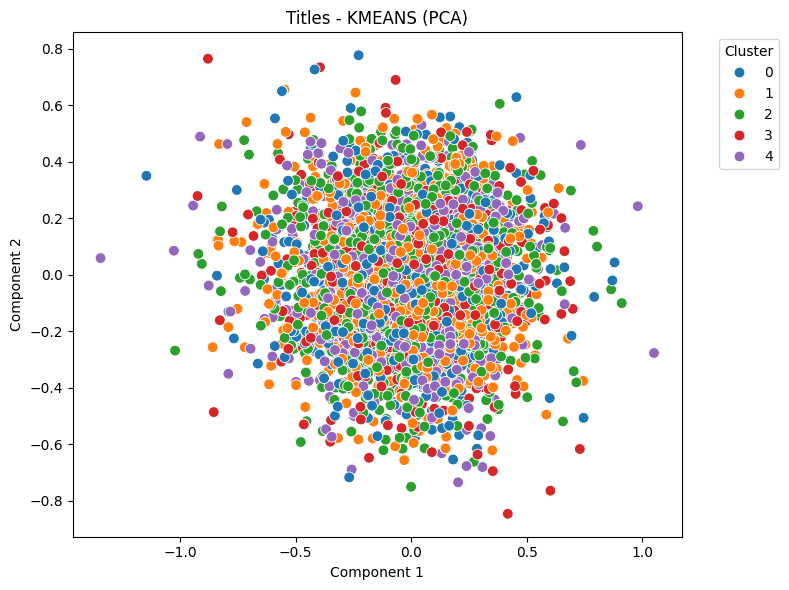

UMAP (visualización):


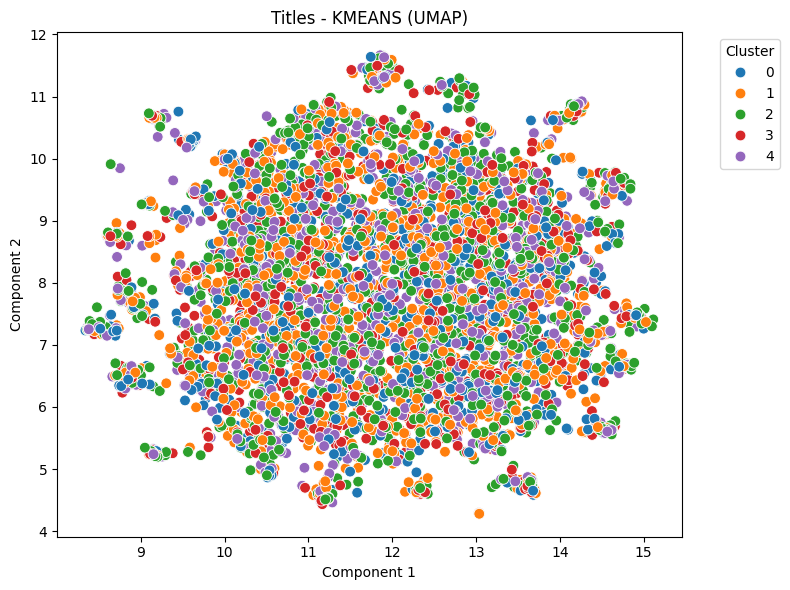

Métricas:
Silhouette Score: 0.028
Davies-Bouldin Index: 3.669
Adjusted Rand Index: 0.118
Homogeneity: 0.238, Completeness: 0.104, V-Measure: 0.145

Ejemplos por cluster:

[Cluster 0]
- The leftist teachers and the press are part of the HUGE problem of misinformation about Donald Trump. They are partly to blame for the violence and ha...
- Wish we could clone this guy   we love Daniel Hannan! We couldn t have said it better! ...
-  In response to the establishment media s contrived  fake news  crisis designed to marginalise independent and alternative media sources of news and a...

[Cluster 1]
- WASHINGTON (Reuters) - U.S. House Democratic Leader Nancy Pelosi agreed on Tuesday to postpone the party’s leadership elections until Nov. 30 amid dis...
- Russia interfered in the 2016 U.S. presidential election in order to help Donald Trump become president of the United States, according to a CIA repor...
- AUSTIN, Texas (Reuters) - U.S. Republican presidential nominee Donald Trump held out 

In [ ]:
clustering_pipeline_fast(X_titles, y, df_total['text'].tolist(), title="Titles", n_clusters=5)

## Recomender system


In [3]:
best_model = MLPClassifier(max_iter=1000)
best_model.fit(X,y)


NameError: name 'MLPClassifier' is not defined

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

class FakeNewsRecommender:
    def __init__(self, model, embeddings, df, vectorize_func, k=1):
        """
        model: trained classifier (e.g., MLP)
        embeddings: array-like of shape (n_samples, n_features), embeddings used for similarity
        df: DataFrame with 'text', 'title', 'target'
        vectorize_func: function that takes (text, title) and returns the embedding
        k: number of recommendations to return
        """
        self.model = model
        self.embeddings = embeddings
        self.df = df
        self.vectorize = vectorize_func
        self.k = k

        # Create index of REAL news
        self.real_mask = self.df['target'] == 1
        self.real_embeddings = self.embeddings[self.real_mask]
        self.df_real = self.df[self.real_mask].reset_index(drop=True)

    def recommend_if_fake(self, text, title=None):
        # Step 1: Vectorize input
        input_vec = self.vectorize(text, title).reshape(1, -1)

        # Step 2: Predict
        pred = self.model.predict(input_vec)[0]
        proba = self.model.predict_proba(input_vec)[0]
        print(f"\n🔍 Prediction: {'REAL' if pred == 1 else 'FAKE'} (Confidence: {proba[pred]:.2f})")

        if pred == 1:
            print("✅ This news is predicted as REAL. No recommendation needed.")
            return

        print("\n⚠️ FAKE news detected. Recommending similar REAL news...\n")

        # Step 3: Recommend similar REAL news
        sims = cosine_similarity(input_vec, self.real_embeddings)[0]
        top_k_idx = sims.argsort()[-self.k:][::-1]

        for i, idx in enumerate(top_k_idx):
            news = self.df_real.iloc[idx]
            print(f"📌 Recommendation #{i+1}")
            print(f"📰 Title: {news['title']}")
            print(f"📄 Snippet: {news['text'][:300]}...")
            print(f"🔗 Similarity Score: {sims[idx]:.4f}")
            print("-" * 80)


In [2]:
recommender = FakeNewsRecommender(model=best_mlp, embeddings=X, df=df_total, vectorize_func=vectorize_input, k=3)

# Predict and recommend
recommender.recommend_if_fake(
    text="Aliens found on the moon! President negotiates interstellar treaty.",
    title="President Meets Aliens"
)

NameError: name 'best_mlp' is not defined